# Analysis


## Table of Contents
1. [Quick Data Look](#quick)
2. [Finding Notes](#find_notes)
3. [Data Generator](#data_gen)

---

<a name="quick"></a>
## Quick Data Look

### Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

from scipy.io import wavfile

import warnings
warnings.filterwarnings('ignore')

### Plotly
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import plotly.plotly as py
from plotly import tools
init_notebook_mode(connected=True)

### Load custom classes

In [2]:
%run classes/music.py
%run classes/music_gen.py

### Load sound

In [3]:
# I'm ignoring sampling rate for the moment (the first arg here)
_, c2    = wavfile.read('sounds/wav/cello_pluck/single/c2.wav')
_, a3    = wavfile.read('sounds/wav/cello_pluck/single/a3.wav')
_, a3_d3 = wavfile.read('sounds/wav/cello_pluck/multi/a3_d3.wav')
_, whis  = wavfile.read('sounds/wav/whistle.wav')

# spliting the wavefile into two channels
c2_chan1,    c2_chan2    = zip(*c2)
a3_chan1,    a3_chan2    = zip(*a3)
a3_d3_chan1, a3_d3_chan2 = zip(*a3_d3)
whis_chan1,  whis_chan2  = zip(*whis)

# Quick plot of the different notes

Two somewhat surprising things:
- The cello sound is more distorted than I would expect
- A human whistle has really high frequency

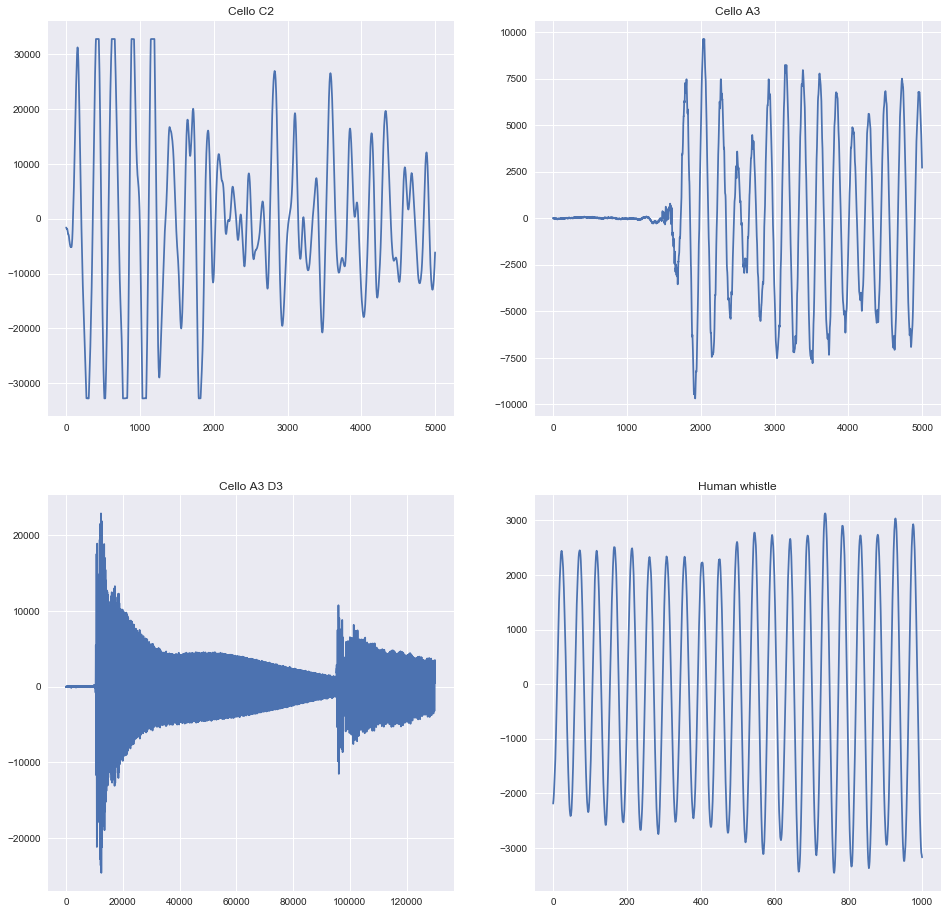

In [4]:
# creating the subplots
fig, axarr = plt.subplots(2, 2, figsize=(16, 16))

# The numbers here needed some tinkering to plot at the right point
axarr[0][0].plot(c2_chan1[70000:75000], "-")
axarr[0][1].plot(a3_chan1[80000:85000], "-")
axarr[1][0].plot(a3_d3_chan1[70000:200000], "-")
axarr[1][1].plot(whis_chan1[70000:71000], "-")

# labeling each plot with it's note
axarr[0][0].set(title="Cello C2")
axarr[0][1].set(title="Cello A3")
axarr[1][0].set(title="Cello A3 D3")
_ = axarr[1][1].set(title="Human whistle")

### A Closer Look

In [7]:
def get_music_df(filepath, START=0, LENGTH=2500):
    sample_rate, music  = wavfile.read(filepath)
    chan1,  chan2  = zip(*music)
    df = pd.Series(chan1[START:START+LENGTH])
    df = pd.DataFrame(df, columns=["Loudness"])
    time = []
    for i in range(len(df)):
        t = (i / sample_rate) * 1000
        time.append(t)
    df["Milliseconds"] = time
    return df

instruments = ("Sitar", "Cello A3", "Human Whistle")

piano = get_music_df('sounds/wav/g_piano.wav', START=10000)
cello = get_music_df('sounds/wav/cello_pluck/single/a3.wav', START=85000)
whistle = get_music_df('sounds/wav/whistle.wav', START=80000)

plotly_data = []
for sound, df in (("Piano", piano),
              ("Cello", cello),
              ("Human Whistle", whistle)):
    trace = go.Scatter(x=list(df.Milliseconds),
                       y=list(df.Loudness),
                       name=sound)
    plotly_data.append(trace)


buttons = []
for i, instrument in enumerate(instruments):
    visibility = [i==j for j in range(len(instruments))]
    button = dict(
                 label =  instrument,
                 method = 'update',
                 args = [{'visible': visibility},
                     {'title': instrument }])
    buttons.append(button)

updatemenus = list([
    dict(
         buttons=buttons
    )
])

layout = dict(title='Different Sounds', 
              updatemenus=updatemenus,
                xaxis=dict(
                    title='mSec',
                    rangeselector=dict(
                        buttons=list([
                            dict(step='all'),
                        ])
                    ),
                    rangeslider=dict(),
                ),
                yaxis=dict(title='Loudness')
             )

fig = dict(data=plotly_data, layout=layout)
iplot(fig)

<a name="find_notes"></a>
## Finding notes

### Load the music and compile

In [8]:
music = Music()
music.read('sounds/wav/cello_pluck/single/a3.wav')
notes = music.compile_music()
notes

,time,id,signal,pitch,given_pitch,loudness,note,octave,alter,duration,typ
0,0.0,45,7115093.96,208.0,207.65,9625,G,3,1,0.25,sixteenth


### Plot the predicted frequency against the actual frequency

My cello appears to be out of tune.  This algorithm pushes the frequency to the closest frequency availiable on the [Western Scale][1].

[1]: https://en.wikipedia.org/wiki/Scale_(music)

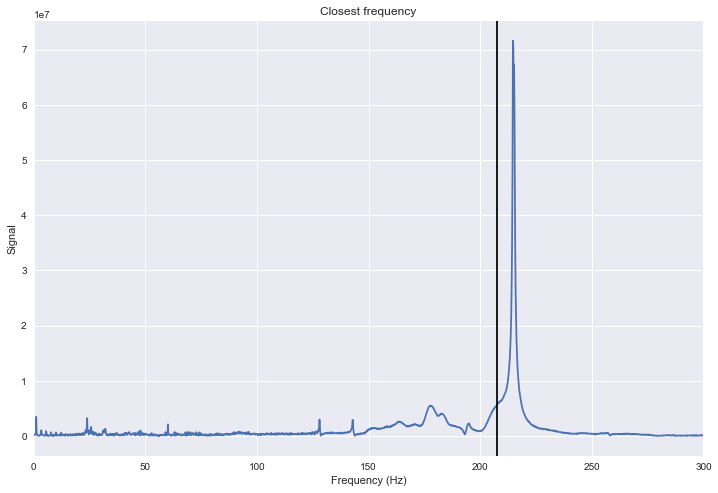

In [9]:
fft_data = np.abs(fft(music.chan1))
conversion_factor = music.sample_rate / len(fft_data)
x = [i * conversion_factor for i in range(len(fft_data))]

plt.figure(figsize=(12, 8))
plt.plot(x, fft_data)
plt.xlim(0, 300)
plt.title("Closest frequency")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Signal")
_ = plt.axvline(notes.iloc[0].given_pitch, color="k")

<a name="data_gen"></a>
## Data generator

### Load music

In [10]:
music = Music()
music.read('sounds/wav/cello_pluck/expert/bach.wav')

### Gets A segment of the music where an instrument is playing

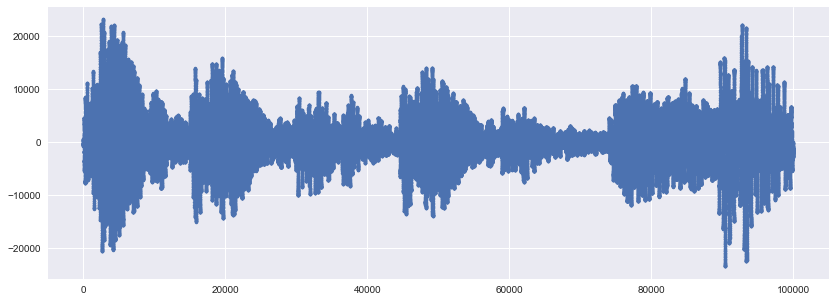

In [11]:
plt.figure(figsize=(14, 5))

seg = music.chan1[300000:400000]
_ = plt.plot(seg, ".")

### Shows 7 generated octaves

Stretch and compress music to different frequencies

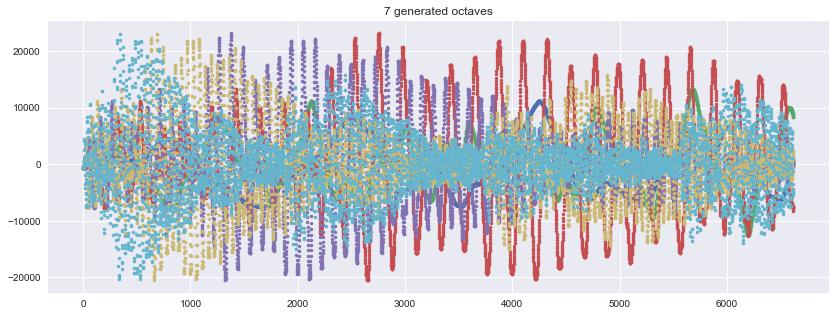

In [12]:
plt.figure(figsize=(14, 5))

segs = Music_Gen(seg).ret()

for s in segs[:84:12]:
    plt.plot(s, ".")
    
_ = plt.title("7 generated octaves")

### Shows 10 generated notes

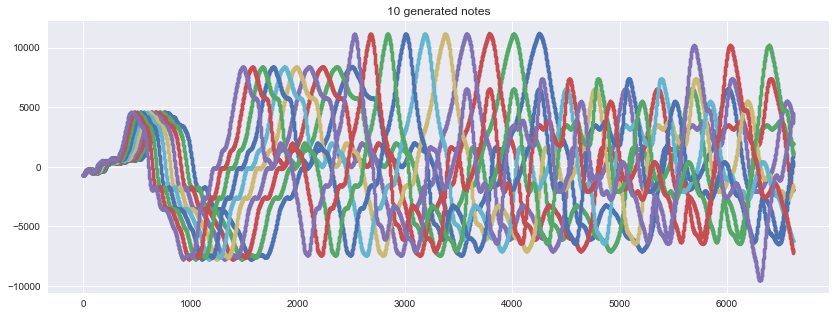

In [13]:
plt.figure(figsize=(14, 5))
for s in segs[:10]:
    plt.plot(s, ".")
_ = plt.title("10 generated notes")